<a href="https://colab.research.google.com/github/nhuyen183/DS-DV-Project/blob/master/ANNss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

import os
from glob import glob
import joblib
import pandas as pd
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import models
from tensorflow.python.keras.models import load_model

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


In [47]:
#@title Load the dataset
filenames = glob('/content/*.csv')
appended_data=[] #create a list
for f in filenames:
    df = pd.read_csv(f, index_col=None)
    appended_data.append(df) #append to the list

df = pd.concat(appended_data, axis=0)

In [3]:
df.head(5)

,Gender,Age65,GeneralHealth,Smoked100,SmokerStatus,FirstSmokedAge,LastSmokedAge,AvgNumCigADay,HasCTScan,StopSmoking,HasAsthma,HasLungCancer
0,1,1,3,1,2,0,0,0,0,1,2,0
1,2,1,3,2,4,0,0,0,0,0,2,0
2,2,2,4,1,3,0,0,0,0,0,2,0
3,1,1,3,1,1,0,0,0,0,1,1,0
4,1,1,4,1,1,0,0,0,0,2,2,0


In [48]:
df.dtypes

Gender           int64
Age65            int64
GeneralHealth    int64
Smoked100        int64
SmokerStatus     int64
                 ...  
AvgNumCigADay    int64
HasCTScan        int64
StopSmoking      int64
HasAsthma        int64
HasLungCancer    int64
Length: 12, dtype: object

In [4]:
df.HasLungCancer.value_counts()

0    371625
1       156
Name: HasLungCancer, dtype: int64

In [49]:
#@title Split data into traning and test sets

train_df = df.sample(frac=0.8, random_state =42)
test_df = df.drop(train_df.index)

In [50]:
#@title Data balancing using SMOTE
#K-nearest neighbor algorithm to simulate the minority sample
from imblearn.over_sampling import SMOTE

count_majority_class, count_minority_class = train_df.HasLungCancer.value_counts()

In [51]:
df_majority_class = train_df[train_df['HasLungCancer'] == 0]
df_minority_class = train_df[train_df['HasLungCancer'] == 1]

In [52]:
df_class_oversample = df_minority_class.sample(count_majority_class, replace=True)

In [53]:
df_balanced_os = pd.concat([df_class_oversample, df_majority_class], axis=0)

In [54]:
print('Number of data samples after over-sampling:')
print(df_balanced_os.HasLungCancer.value_counts())

Number of data samples after over-sampling:
1    297294
0    297294
Name: HasLungCancer, dtype: int64


In [41]:
#X = df_balanced_os.iloc[:, 0:11].astype(int)
#y = df_balanced_os['HasLungCancer'].astype(int)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
#@title Create numeric feature columns
# For Numeric features, we can just call on feature_column.numeric_column()
# to use its raw value instead of having to create a map between value and ID.
gender = tf.feature_column.numeric_column("Gender")
age = tf.feature_column.numeric_column("Age65")
genhealth = tf.feature_column.numeric_column("GeneralHealth")
smoked100 = tf.feature_column.numeric_column("Smoked100")
firstsmoked_age = tf.feature_column.numeric_column("FirstSmokedAge")
lastsmoked_age = tf.feature_column.numeric_column("LastSmokedAge")
avg_numcig_day = tf.feature_column.numeric_column("AvgNumCigADay")
scan = tf.feature_column.numeric_column("HasCTScan")
stopsmoked_attempt = tf.feature_column.numeric_column("StopSmoking")
has_asthma = tf.feature_column.numeric_column("HasAsthma")

In [56]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = [gender, age, genhealth, smoked100, firstsmoked_age, lastsmoked_age, avg_numcig_day, scan, stopsmoked_attempt, has_asthma]

# Convert the list of feature columns into a layer that will later be fed into the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [57]:
#@title Define the plotting function.

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [58]:
#@title Define functions to create and train a linear regression model
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model           


def train_model(model, df, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in df.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Epoch 1/15


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


595/595 [==============================] - 2s 2ms/step - loss: 4.5938 - mean_squared_error: 4.5938
Epoch 2/15
595/595 [==============================] - 1s 3ms/step - loss: 0.1880 - mean_squared_error: 0.1880
Epoch 3/15
595/595 [==============================] - 2s 3ms/step - loss: 0.1883 - mean_squared_error: 0.1883
Epoch 4/15
595/595 [==============================] - 1s 3ms/step - loss: 0.1878 - mean_squared_error: 0.1878
Epoch 5/15
595/595 [==============================] - 1s 2ms/step - loss: 0.1879 - mean_squared_error: 0.1879
Epoch 6/15
595/595 [==============================] - 2s 3ms/step - loss: 0.1879 - mean_squared_error: 0.1879
Epoch 7/15
595/595 [==============================] - 2s 3ms/step - loss: 0.1882 - mean_squared_error: 0.1882
Epoch 8/15
595/595 [==============================] - 2s 3ms/step - loss: 0.1878 - mean_squared_error: 0.1878
Epoch 9/15
595/595 [==============================] - 2s 3ms/step - loss: 0.1881 - mean_squared_error: 0.1881
Epoch 10/15
595/595 [

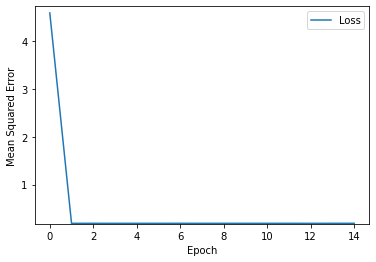


 Evaluate the linear regression model against the test set:


4/4 [==============================] - 0s 3ms/step - loss: 0.1529 - mean_squared_error: 0.1529


[0.15293049812316895, 0.15293049812316895]

In [59]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "HasLungCancer"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the training set.
epochs, mse = train_model(my_model, df_balanced_os, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

In [90]:
#@title Define Deep Neural Net Model

def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  # Define the second hidden layer with 12 nodes. 
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  name='Hidden2'))
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=2,  
                                  name='Output'))                      
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

In [91]:
def train_model(model, df, epochs, label_name,
                batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in df.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]
  

  return epochs, mse

Epoch 1/20


595/595 [==============================] - 2s 3ms/step - loss: 0.1683 - mean_squared_error: 0.1683
Epoch 2/20
595/595 [==============================] - 2s 3ms/step - loss: 0.1257 - mean_squared_error: 0.1257
Epoch 3/20
595/595 [==============================] - 2s 3ms/step - loss: 0.1228 - mean_squared_error: 0.1228
Epoch 4/20
595/595 [==============================] - 2s 3ms/step - loss: 0.1212 - mean_squared_error: 0.1212
Epoch 5/20
595/595 [==============================] - 2s 3ms/step - loss: 0.1196 - mean_squared_error: 0.1196
Epoch 6/20
595/595 [==============================] - 2s 3ms/step - loss: 0.1190 - mean_squared_error: 0.1190
Epoch 7/20
595/595 [==============================] - 2s 3ms/step - loss: 0.1186 - mean_squared_error: 0.1186
Epoch 8/20
595/595 [==============================] - 2s 3ms/step - loss: 0.1183 - mean_squared_error: 0.1183
Epoch 9/20
595/595 [==============================] - 2s 3ms/step - loss: 0.1170 - mean_squared_error: 0.1170
Epoch 10/20
595/595 [

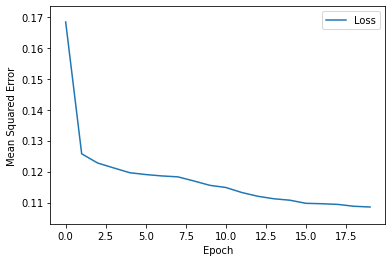


 Evaluate the new model against the test set:
4/4 [==============================] - 0s 4ms/step - loss: 0.1260 - mean_squared_error: 0.1260


[0.1260349452495575, 0.1260349452495575]

In [92]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "HasLungCancer"
    
    
# List of built-in metrics that we'll need to evaluate performance.
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
  ]        

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, df_balanced_os, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

In [ ]:
my_model.predict()